In [1]:
import os
import sys
import h5py
import json
import importlib
import numpy as np
import torch as pt
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from scipy import signal
from sklearn import metrics
from matplotlib import rcParams

import src as sp
import runtime as rt
from theme import colors

# font parameters
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 12

In [2]:
# parameters
results_dir = "results/benchmark"

# reload results
df = pd.concat([pd.read_csv(fp) for fp in glob(os.path.join(results_dir, "*.csv"))])

In [3]:
df[df['type'] == "aa"].mean(numeric_only=True)

size                          391.923120
recovery_rate                   0.567693
sequence_similarity             0.737133
maximum_recovery_rate           0.874818
average_multiplicity            3.629284
average_maximum_confidence      0.924959
average_maximum_score           0.580519
dtype: float64

In [4]:
df[df['type'] == "aa"].std(numeric_only=True)

size                          210.116333
recovery_rate                   0.084502
sequence_similarity             0.066593
maximum_recovery_rate           0.041039
average_multiplicity            0.586695
average_maximum_confidence      0.020319
average_maximum_score           0.071762
dtype: float64

In [18]:
df.shape

(64740, 9)

### Plots

In [5]:
def set_violinplot_color(vp, color):
    vp['cmedians'].set_edgecolor(color)
    for pc in vp['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)

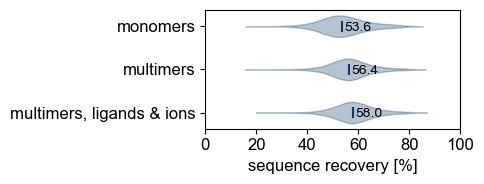

In [6]:
msr_name = "recovery_rate"
labels = ["monomers", "multimers", "multimers, ligands & ions"]

y = [
    1e2*df[df['type'].str[0] == 's'][msr_name].values,
    1e2*df[df['type'] == 'aa'][msr_name].values,
    1e2*df[df['type'] == 'all'][msr_name].values,
]
x = np.arange(len(y))[::-1]
my = np.array([np.median(yi) for yi in y])

plt.figure(figsize=(5,2))
vp = plt.violinplot(y, x, vert=False, showextrema=False, showmedians=True)
set_violinplot_color(vp, colors[1])
for i in range(len(my)):
    plt.text(my[i]+1.0, x[i], '{:.1f}'.format(my[i]), va='center_baseline', size=10)
plt.yticks(x, labels, rotation=0)
plt.xlim(0, 100)
plt.xlabel("sequence recovery [%]")
plt.tight_layout()
plt.savefig("graphs/recovery_with_context.svg")
plt.show()

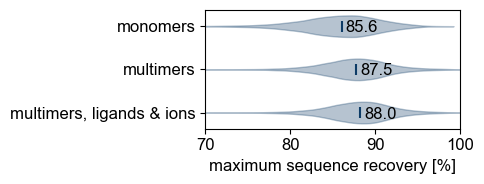

In [7]:
msr_name = "maximum_recovery_rate"
labels = ["monomers", "multimers", "multimers, ligands & ions"]

y = [
    1e2*df[df['type'].str[0] == 's'][msr_name].values,
    1e2*df[df['type'] == 'aa'][msr_name].values,
    1e2*df[df['type'] == 'all'][msr_name].values,
]
x = np.arange(len(y))[::-1]
my = np.array([np.mean(yi) for yi in y])

plt.figure(figsize=(5,2))
vp = plt.violinplot(y, x, vert=False, showextrema=False, showmedians=True)
set_violinplot_color(vp, colors[1])
for i in range(len(my)):
    plt.text(my[i]+0.8, x[i], '{:.1f}'.format(my[i]), va='center_baseline')
plt.yticks(x, labels, rotation=0)
plt.xlim(70, 100)
plt.xlabel("maximum sequence recovery [%]")
plt.tight_layout()
#plt.savefig("graphs/maximum_recovery_with_context_{}.svg".format(name))
plt.show()

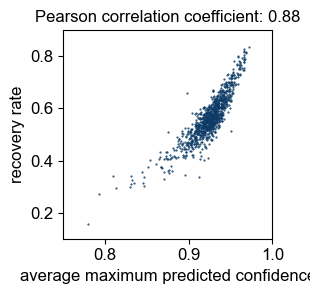

In [12]:
# parameters
msr_name = "maximum_recovery_rate"
labels = ["monomers", "multimers", "multimers, ligands & ions"]

# scores
x = df[df['type'] == 'aa']['average_maximum_confidence'].values[::20]
y = df[df['type'] == 'aa']['recovery_rate'].values[::20]
corr = np.corrcoef(x,y)[0,1]

# plot
plt.figure(figsize=(3.1,3.1))
plt.plot(x, y, '.', ms=1.0, color=colors[1])
plt.xlim(0.75, 1.0)
plt.ylim(0.1, 0.9)
plt.title('Pearson correlation coefficient: {:.2f}'.format(corr), fontsize=12)
#plt.axis('equal')
plt.xlabel('average maximum predicted confidence')
plt.ylabel('recovery rate')
plt.tight_layout()
plt.savefig("graphs/prediction_confidence_vs_recovery_rate.svg")
plt.show()

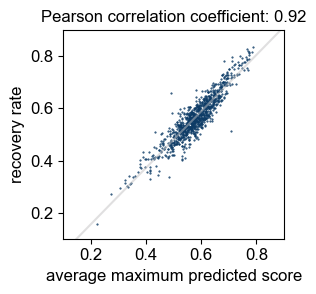

In [13]:
# parameters
msr_name = "maximum_recovery_rate"
labels = ["monomers", "multimers", "multimers, ligands & ions"]

# scores
x = df[df['type'] == 'aa']['average_maximum_score'].values[::20]
y = df[df['type'] == 'aa']['recovery_rate'].values[::20]
corr = np.corrcoef(x,y)[0,1]

# linear fit
ws = np.polyfit(x, y, 1)
xs = np.linspace(0.0, 1.0, 100)
ys = ws[0] * xs + ws[1]

# plot
plt.figure(figsize=(3.1,3.1))
plt.plot(x, y, '.', ms=1.0, color=colors[1])
plt.plot(xs, ys, '-', alpha=0.5, color=colors[3], label='{:.2f}x {} {:.2f}'.format(ws[0], {-1.0:'-', 1.0:'+'}[np.sign(ws[1])], np.abs(ws[1])))
plt.xlim(0.1, 0.9)
plt.ylim(0.1, 0.9)
plt.title('Pearson correlation coefficient: {:.2f}'.format(corr), fontsize=12)
#plt.axis('equal')
plt.xlabel('average maximum predicted score')
plt.ylabel('recovery rate')
plt.tight_layout()
plt.savefig("graphs/confidence_score_vs_recovery_rate.svg")
plt.show()